# NB10: Review Improvements — Supplementary Analyses

**Purpose**: Address 2 critical and 4 important suggestions from automated review (REVIEW.md).

**Approach**: Single supplementary notebook using pandas/scipy only (no Spark). All inputs are saved data files from NB01–NB09. Existing notebooks are NOT modified.

**Sections**:
1. Gene-to-Gap Enzymatic Matching (Critical #1)
2. Robust Rank Indicators (Critical #2)
3. Species-Count Pangenome Scoring (Important #3)
4. NMDC Permutation Null Approximation (Important #4)
5. Biogeographic Null & Binomial Test (Important #5 + #6)

**Inputs**:
- `data/gapmind_gap_candidates.tsv` (1,256 rows)
- `data/phylogenetic_breadth.tsv` (30,756 rows)
- `data/dark_genes_integrated.tsv` (228,709 rows)
- `data/scoring_all_dark.tsv` (17,344 rows)
- `data/essential_dark_scored.tsv` (9,557 rows)
- `data/scoring_sensitivity_nb05.tsv` (6 configs)
- `data/scoring_sensitivity_nb07.tsv` (6 configs)
- `data/nmdc_validation.tsv` (105 rows)
- `data/nmdc_trait_validation.tsv` (456 rows)
- `data/lab_field_concordance.tsv` (47 rows)

**Outputs**:
- `data/gapmind_domain_matched.tsv`
- `data/robust_ranks_fitness.tsv`
- `data/robust_ranks_essential.tsv`
- `data/scoring_species_count_variant.tsv`
- `figures/fig28_domain_matching.png`
- `figures/fig29_robust_ranks.png`
- `figures/fig30_species_count_scoring.png`
- `figures/fig31_statistical_tests.png`

**Dependencies**: NB01–NB09 (all data files pre-computed)

In [1]:
import pandas as pd
import numpy as np
import os
import re
import ast
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Path setup
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print(f'Project dir: {PROJECT_DIR}')
print(f'Data dir: {DATA_DIR}')
print(f'Figure dir: {FIG_DIR}')

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter
Data dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/data
Figure dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/figures


---
## Section 1: Gene-to-Gap Enzymatic Matching (Critical #1)

The automated review noted that NB02's GapMind analysis identifies organism-level co-occurrences of pathway gaps and dark genes, but does not perform direct gene-to-gap enzymatic matching. This section defines curated pathway-enzyme mappings and matches dark gene annotations (EC numbers, PFam domains, functional keywords) to gap-bearing pathways.

In [2]:
# Load input data
gapmind = pd.read_csv(os.path.join(DATA_DIR, 'gapmind_gap_candidates.tsv'), sep='\t')
phylo = pd.read_csv(os.path.join(DATA_DIR, 'phylogenetic_breadth.tsv'), sep='\t')
dark_all = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t')

print(f'GapMind gap candidates: {len(gapmind)} organism-pathway pairs')
print(f'Phylogenetic breadth: {len(phylo)} gene clusters')
print(f'Dark genes integrated: {len(dark_all)} total genes')
print(f'Dark genes only: {dark_all["is_dark"].sum()}')

/tmp/ipykernel_57153/173307532.py:4: DtypeWarning: Columns (0: gene, 1: module, 2: familyId, 3: module_prediction, 4: prediction_source, 5: top_cofit_partners) have mixed types. Specify dtype option on import or set low_memory=False.
  dark_all = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t')


GapMind gap candidates: 1256 organism-pathway pairs
Phylogenetic breadth: 30756 gene clusters
Dark genes integrated: 228709 total genes
Dark genes only: 57011


In [3]:
# Curated pathway-enzyme mapping
# Two levels: specific (top ~15 most-gapped pathways) and category fallback

PATHWAY_ENZYMES = {
    # Carbon utilization pathways
    'fucose': {
        'ec_prefixes': ['5.3.1', '1.1.1', '2.7.1', '4.1.2', '4.2.1'],
        'pfam_families': ['Aldolase', 'Sugar_tr', 'Aldose_epim', 'FucI', 'MFS_1', 'Isomerase'],
        'keywords': ['fucose', 'aldolase', 'isomerase', 'kinase', 'dehydrogenase', 'sugar']
    },
    'rhamnose': {
        'ec_prefixes': ['5.3.1', '4.1.2', '1.1.1', '2.7.1'],
        'pfam_families': ['Aldolase', 'Sugar_tr', 'Aldose_epim', 'MFS_1', 'RhaA', 'Isomerase'],
        'keywords': ['rhamnose', 'aldolase', 'isomerase', 'dehydrogenase', 'kinase', 'sugar']
    },
    'sorbitol': {
        'ec_prefixes': ['1.1.1', '2.7.1', '5.1.3'],
        'pfam_families': ['Sugar_tr', 'PTS_EIIA', 'PTS_EIIB', 'PTS_EIIC', 'MFS_1', 'Sorbitol_DH'],
        'keywords': ['sorbitol', 'glucitol', 'polyol', 'dehydrogenase', 'PTS', 'sugar']
    },
    'myoinositol': {
        'ec_prefixes': ['5.5.1', '1.1.1', '4.2.1', '3.7.1'],
        'pfam_families': ['Sugar_tr', 'IolE', 'Ald_DH_CSA', 'MFS_1'],
        'keywords': ['inositol', 'myo-inositol', 'dehydrogenase', 'dehydratase', 'aldolase']
    },
    'gluconate': {
        'ec_prefixes': ['2.7.1', '4.1.2', '1.1.1'],
        'pfam_families': ['Aldolase', 'GntR', 'Sugar_tr', 'MFS_1', 'GNTP'],
        'keywords': ['gluconate', 'kinase', 'dehydrogenase', 'aldolase', 'transporter']
    },
    'cellobiose': {
        'ec_prefixes': ['3.2.1', '2.7.1'],
        'pfam_families': ['Glyco_hydro', 'PTS_EIIA', 'PTS_EIIB', 'PTS_EIIC', 'Sugar_tr', 'MFS_1', 'Cellulase'],
        'keywords': ['cellobiose', 'glucosidase', 'cellulase', 'beta-glucosidase', 'PTS', 'sugar']
    },
    'mannitol': {
        'ec_prefixes': ['1.1.1', '2.7.1'],
        'pfam_families': ['Sugar_tr', 'PTS_EIIA', 'PTS_EIIB', 'PTS_EIIC', 'MFS_1', 'Mannitol_dh'],
        'keywords': ['mannitol', 'dehydrogenase', 'PTS', 'sugar']
    },
    'trehalose': {
        'ec_prefixes': ['3.2.1', '2.4.1', '5.4.99'],
        'pfam_families': ['Glyco_hydro', 'Sugar_tr', 'Trehalase', 'MFS_1'],
        'keywords': ['trehalose', 'trehalase', 'maltooligosyl', 'sugar']
    },
    'xylitol': {
        'ec_prefixes': ['1.1.1', '2.7.1'],
        'pfam_families': ['Sugar_tr', 'Xylose_isom', 'MFS_1'],
        'keywords': ['xylitol', 'xylulose', 'xylose', 'dehydrogenase', 'sugar']
    },
    'galactitol': {
        'ec_prefixes': ['1.1.1', '2.7.1'],
        'pfam_families': ['Sugar_tr', 'PTS_EIIA', 'PTS_EIIB', 'PTS_EIIC', 'MFS_1'],
        'keywords': ['galactitol', 'tagatose', 'dehydrogenase', 'sugar']
    },
    # Amino acid pathways
    'asn': {
        'ec_prefixes': ['6.3.5', '6.3.1', '2.6.1'],
        'pfam_families': ['Asn_synthase', 'GATase', 'Aminotran'],
        'keywords': ['asparagine', 'synthetase', 'synthase', 'aminotransferase']
    },
    'trp': {
        'ec_prefixes': ['4.1.3', '4.2.1', '2.4.2', '5.3.1'],
        'pfam_families': ['Trp_syntA', 'Trp_syntB', 'IGPS', 'Anthranilate'],
        'keywords': ['tryptophan', 'anthranilate', 'indole', 'synthase']
    },
    'his': {
        'ec_prefixes': ['2.4.2', '3.6.1', '5.3.1', '4.2.1', '2.6.1'],
        'pfam_families': ['HisG', 'HisA', 'HisF', 'Histidinol_dh', 'Aminotran'],
        'keywords': ['histidine', 'histidinol', 'imidazole', 'synthase']
    },
    'thr': {
        'ec_prefixes': ['2.7.2', '1.1.1', '4.2.3', '2.7.1'],
        'pfam_families': ['AA_kinase', 'Homoserine_dh', 'Thr_dehydrat'],
        'keywords': ['threonine', 'homoserine', 'kinase', 'dehydrogenase', 'synthase']
    },
    'met': {
        'ec_prefixes': ['2.1.1', '4.2.1', '2.5.1'],
        'pfam_families': ['Methyltransf', 'Met_synt', 'Cys_Met_Meta_PP'],
        'keywords': ['methionine', 'methyltransferase', 'homocysteine', 'synthase']
    },
}

# Category-level fallback for pathways not in the specific dict
CATEGORY_ENZYMES = {
    'carbon': {
        'ec_prefixes': ['1.1.1', '2.7.1', '3.2.1', '4.1.2', '4.2.1', '5.3.1', '5.1.3'],
        'pfam_families': ['Sugar_tr', 'MFS_1', 'PTS_EIIA', 'PTS_EIIB', 'PTS_EIIC',
                          'Glyco_hydro', 'Aldolase', 'Isomerase'],
        'keywords': ['sugar', 'transporter', 'kinase', 'dehydrogenase', 'aldolase',
                      'hydrolase', 'isomerase', 'carbohydrate']
    },
    'aa': {
        'ec_prefixes': ['2.6.1', '6.3.5', '4.3.1', '2.1.1', '1.1.1', '4.2.1'],
        'pfam_families': ['Aminotran', 'GATase', 'AA_kinase', 'Methyltransf'],
        'keywords': ['synthase', 'synthetase', 'aminotransferase', 'biosynthesis',
                      'dehydrogenase', 'kinase', 'amino acid']
    }
}

print(f'Specific pathway-enzyme mappings: {len(PATHWAY_ENZYMES)} pathways')
print(f'Category fallbacks: {len(CATEGORY_ENZYMES)} categories')

Specific pathway-enzyme mappings: 15 pathways
Category fallbacks: 2 categories


In [4]:
# Build per-dark-gene annotation index
# Sources: domain_names + module_prediction EC extraction + phylogenetic_breadth (EC, PFAMs, KEGG_ko)

dark_genes = dark_all[dark_all['is_dark'] == True].copy()
print(f'Dark genes: {len(dark_genes)}')

# 1. Extract annotations from dark_genes_integrated
def extract_ec_numbers(text):
    """Extract EC numbers from module_prediction or description text."""
    if pd.isna(text) or not isinstance(text, str):
        return set()
    return set(re.findall(r'EC\s*(\d+\.\d+\.\d+\.\d+)', text)) | \
           set(re.findall(r'(\d+\.\d+\.\d+\.\d+)', text))

def extract_domains(text):
    """Split domain_names into set of individual domains."""
    if pd.isna(text) or not isinstance(text, str):
        return set()
    return set(d.strip() for d in text.split('|') if d.strip())

def safe_str(val, default=''):
    """Convert value to string, handling NaN/None."""
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return default
    return str(val)

# Build annotation index: orgId+locusId -> annotations
gene_annotations = {}

for _, row in dark_genes.iterrows():
    key = (row['orgId'], row['locusId'])
    ec_nums = extract_ec_numbers(safe_str(row.get('module_prediction', '')))
    domains = extract_domains(safe_str(row.get('domain_names', '')))
    gc_id = row.get('gene_cluster_id', None)
    if isinstance(gc_id, float) and np.isnan(gc_id):
        gc_id = None
    
    maf = row.get('max_abs_fit', 0)
    maf = 0.0 if (maf is None or (isinstance(maf, float) and np.isnan(maf))) else float(maf)

    gene_annotations[key] = {
        'ec_numbers': ec_nums,
        'domains': domains,
        'gene_cluster_id': gc_id,
        'module_prediction': safe_str(row.get('module_prediction', '')),
        'max_abs_fit': maf,
        'desc': safe_str(row.get('desc', '')),
    }

# 2. Enrich with phylogenetic_breadth (EC, PFAMs, KEGG_ko)
phylo_annot = phylo[['gene_cluster_id', 'EC', 'PFAMs', 'KEGG_ko', 'Description']].copy()
phylo_dict = {}
for _, row in phylo_annot.iterrows():
    gc_id = row['gene_cluster_id']
    ec = set() if pd.isna(row['EC']) or row['EC'] == '-' else set(str(row['EC']).split(','))
    pfams = set() if pd.isna(row['PFAMs']) or row['PFAMs'] == '-' else set(str(row['PFAMs']).split(','))
    kegg = set() if pd.isna(row['KEGG_ko']) or row['KEGG_ko'] == '-' else set(str(row['KEGG_ko']).split(','))
    desc = '' if pd.isna(row['Description']) or row['Description'] == '-' else str(row['Description'])
    phylo_dict[gc_id] = {'ec': ec, 'pfams': pfams, 'kegg': kegg, 'desc': desc}

# Merge phylo annotations into gene_annotations
enriched = 0
for key, annot in gene_annotations.items():
    gc_id = annot['gene_cluster_id']
    if gc_id and gc_id in phylo_dict:
        p = phylo_dict[gc_id]
        annot['ec_numbers'] |= p['ec']
        annot['domains'] |= p['pfams']
        annot['kegg_ko'] = p['kegg']
        annot['phylo_desc'] = p['desc']
        enriched += 1
    else:
        annot['kegg_ko'] = set()
        annot['phylo_desc'] = ''

print(f'Gene annotation index: {len(gene_annotations)} dark genes')
print(f'Enriched with phylogenetic_breadth: {enriched}')

# Count genes with any annotation
has_ec = sum(1 for a in gene_annotations.values() if a['ec_numbers'])
has_domain = sum(1 for a in gene_annotations.values() if a['domains'])
has_any = sum(1 for a in gene_annotations.values() if a['ec_numbers'] or a['domains'])
print(f'Genes with EC numbers: {has_ec}')
print(f'Genes with domain annotations: {has_domain}')
print(f'Genes with any annotation: {has_any}')

Dark genes: 57011


Gene annotation index: 57011 dark genes
Enriched with phylogenetic_breadth: 32791
Genes with EC numbers: 1312
Genes with domain annotations: 29479
Genes with any annotation: 29581


In [5]:
# Match dark genes to gapped pathways using enzyme/domain/keyword compatibility

def match_gene_to_pathway(annot, pathway_name, metabolic_category):
    """Check if a dark gene's annotations are compatible with a gapped pathway.
    Returns (match_type, confidence_tier, matched_annotation) or None."""
    
    # Get pathway-specific or category fallback enzymes
    pathway_key = pathway_name.lower().replace(' ', '_').replace('-', '_')
    # Try exact match first, then partial
    enzymes = None
    for pkey in PATHWAY_ENZYMES:
        if pkey in pathway_key or pathway_key in pkey:
            enzymes = PATHWAY_ENZYMES[pkey]
            break
    if enzymes is None:
        # Category fallback
        cat_key = 'aa' if metabolic_category == 'aa' else 'carbon'
        enzymes = CATEGORY_ENZYMES.get(cat_key)
        if enzymes is None:
            return None
    
    # High confidence: EC prefix match
    for ec in annot['ec_numbers']:
        for prefix in enzymes['ec_prefixes']:
            if ec.startswith(prefix):
                return ('EC_match', 'High', f'EC:{ec}')
    
    # Medium confidence: PFam family match
    for domain in annot['domains']:
        for pfam in enzymes['pfam_families']:
            if pfam.lower() in domain.lower() or domain.lower() in pfam.lower():
                return ('PFam_match', 'Medium', f'PFam:{domain}')
    
    # Low confidence: keyword match in module_prediction or phylo_desc
    text_parts = [
        annot.get('module_prediction', ''),
        annot.get('phylo_desc', ''),
        annot.get('desc', ''),
        ' '.join(str(d) for d in annot.get('domains', set())),
    ]
    text = ' '.join(str(t) for t in text_parts).lower()
    for kw in enzymes['keywords']:
        if kw.lower() in text:
            return ('keyword_match', 'Low', f'keyword:{kw}')
    
    return None

# Pre-index dark genes by organism for efficient lookup
from collections import defaultdict
org_gene_index = defaultdict(list)
for key, annot in gene_annotations.items():
    org_gene_index[key[0]].append((key, annot))
print(f'Organisms with dark genes: {len(org_gene_index)}')

# For each organism-pathway pair, find matching dark genes
matches = []
for _, gap_row in gapmind.iterrows():
    org_id = gap_row['orgId']
    pathway = gap_row['pathway']
    category = gap_row['metabolic_category']
    
    # Get dark genes for this organism (pre-indexed)
    org_genes = org_gene_index.get(org_id, [])
    
    for (o, locus), annot in org_genes:
        result = match_gene_to_pathway(annot, pathway, category)
        if result:
            match_type, confidence, matched_annot = result
            matches.append({
                'orgId': org_id,
                'pathway': pathway,
                'metabolic_category': category,
                'locusId': locus,
                'gene_cluster_id': annot['gene_cluster_id'],
                'match_type': match_type,
                'confidence_tier': confidence,
                'matched_annotation': matched_annot,
                'max_abs_fit': annot['max_abs_fit'],
            })

domain_matched = pd.DataFrame(matches)
print(f'Total domain-matched candidates: {len(domain_matched)}')
print(f'  High confidence (EC match): {(domain_matched["confidence_tier"] == "High").sum()}')
print(f'  Medium confidence (PFam match): {(domain_matched["confidence_tier"] == "Medium").sum()}')
print(f'  Low confidence (keyword match): {(domain_matched["confidence_tier"] == "Low").sum()}')
print(f'Unique genes matched: {domain_matched[["orgId", "locusId"]].drop_duplicates().shape[0]}')
print(f'Unique pathways with matches: {domain_matched["pathway"].nunique()}')
print(f'Unique organisms with matches: {domain_matched["orgId"].nunique()}')

Organisms with dark genes: 48


Total domain-matched candidates: 42239
  High confidence (EC match): 5398
  Medium confidence (PFam match): 4687
  Low confidence (keyword match): 32154
Unique genes matched: 3186
Unique pathways with matches: 78
Unique organisms with matches: 44


In [6]:
# Save domain-matched candidates
domain_matched.to_csv(os.path.join(DATA_DIR, 'gapmind_domain_matched.tsv'), sep='\t', index=False)
print(f'Saved: data/gapmind_domain_matched.tsv ({len(domain_matched)} rows)')

Saved: data/gapmind_domain_matched.tsv (42239 rows)


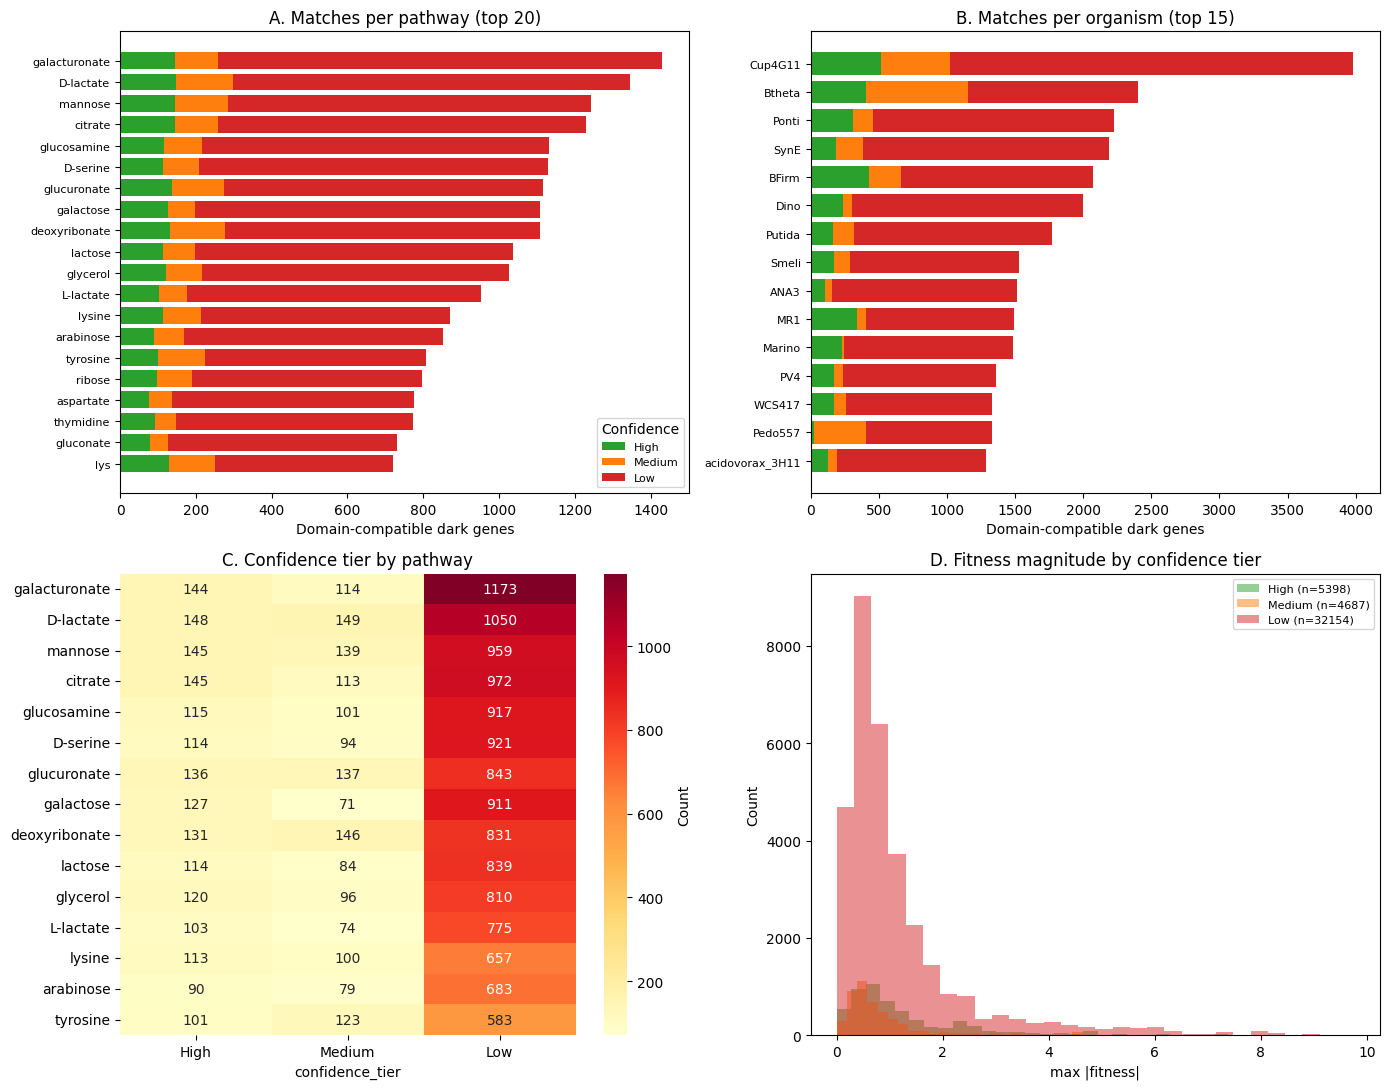

Saved: figures/fig28_domain_matching.png


In [7]:
# Figure 28: Domain matching summary (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# (A) Matches per pathway (top 20)
ax = axes[0, 0]
pathway_counts = domain_matched.groupby('pathway').size().sort_values(ascending=False).head(20)
colors_tier = {'High': '#2ca02c', 'Medium': '#ff7f0e', 'Low': '#d62728'}
# Stacked by confidence tier
pw_tier = domain_matched.groupby(['pathway', 'confidence_tier']).size().unstack(fill_value=0)
pw_tier = pw_tier.loc[pathway_counts.index]
for tier in ['Low', 'Medium', 'High']:
    if tier not in pw_tier.columns:
        pw_tier[tier] = 0
bottom = np.zeros(len(pw_tier))
for tier in ['High', 'Medium', 'Low']:
    vals = pw_tier[tier].values
    ax.barh(range(len(pw_tier)), vals, left=bottom, color=colors_tier[tier], label=tier)
    bottom += vals
ax.set_yticks(range(len(pw_tier)))
ax.set_yticklabels(pw_tier.index, fontsize=8)
ax.set_xlabel('Domain-compatible dark genes')
ax.set_title('A. Matches per pathway (top 20)')
ax.legend(title='Confidence', fontsize=8)
ax.invert_yaxis()

# (B) Matches per organism (top 15)
ax = axes[0, 1]
org_counts = domain_matched.groupby('orgId').size().sort_values(ascending=False).head(15)
org_tier = domain_matched.groupby(['orgId', 'confidence_tier']).size().unstack(fill_value=0)
org_tier = org_tier.loc[org_counts.index]
for tier in ['Low', 'Medium', 'High']:
    if tier not in org_tier.columns:
        org_tier[tier] = 0
bottom = np.zeros(len(org_tier))
for tier in ['High', 'Medium', 'Low']:
    vals = org_tier[tier].values
    ax.barh(range(len(org_tier)), vals, left=bottom, color=colors_tier[tier], label=tier)
    bottom += vals
ax.set_yticks(range(len(org_tier)))
ax.set_yticklabels(org_tier.index, fontsize=8)
ax.set_xlabel('Domain-compatible dark genes')
ax.set_title('B. Matches per organism (top 15)')
ax.invert_yaxis()

# (C) Heatmap: pathway x confidence tier counts
ax = axes[1, 0]
top_pathways = domain_matched.groupby('pathway').size().sort_values(ascending=False).head(15).index
hm_data = domain_matched[domain_matched['pathway'].isin(top_pathways)].groupby(
    ['pathway', 'confidence_tier']).size().unstack(fill_value=0)
for tier in ['High', 'Medium', 'Low']:
    if tier not in hm_data.columns:
        hm_data[tier] = 0
hm_data = hm_data[['High', 'Medium', 'Low']]
hm_data = hm_data.loc[top_pathways]
sns.heatmap(hm_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('C. Confidence tier by pathway')
ax.set_ylabel('')

# (D) Fitness magnitude distribution by confidence tier
ax = axes[1, 1]
for tier, color in colors_tier.items():
    subset = domain_matched[domain_matched['confidence_tier'] == tier]['max_abs_fit'].dropna()
    if len(subset) > 0:
        ax.hist(subset, bins=30, alpha=0.5, color=color, label=f'{tier} (n={len(subset)})')
ax.set_xlabel('max |fitness|')
ax.set_ylabel('Count')
ax.set_title('D. Fitness magnitude by confidence tier')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig28_domain_matching.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/fig28_domain_matching.png')

---
## Section 2: Robust Rank Indicators (Critical #2)

The automated review noted that scoring weight sensitivity analysis (NB05/NB07) shows top-50 lists are moderately sensitive to weight choices, but did not report which specific candidates are robust across all configurations. This section computes per-gene rank ranges across all sensitivity configurations.

In [8]:
# Load scoring data and sensitivity configs
scored_fitness = pd.read_csv(os.path.join(DATA_DIR, 'scoring_all_dark.tsv'), sep='\t')
scored_essential = pd.read_csv(os.path.join(DATA_DIR, 'essential_dark_scored.tsv'), sep='\t')
sens_nb05 = pd.read_csv(os.path.join(DATA_DIR, 'scoring_sensitivity_nb05.tsv'), sep='\t')
sens_nb07 = pd.read_csv(os.path.join(DATA_DIR, 'scoring_sensitivity_nb07.tsv'), sep='\t')

print(f'Fitness-active scored: {len(scored_fitness)}')
print(f'Essential scored: {len(scored_essential)}')
print(f'NB05 sensitivity configs: {len(sens_nb05)}')
print(f'NB07 sensitivity configs: {len(sens_nb07)}')

Fitness-active scored: 17344
Essential scored: 9557
NB05 sensitivity configs: 6
NB07 sensitivity configs: 6


In [9]:
# Parse weight dicts and compute ranks under each config for fitness-active genes

fitness_components = ['s_fitness', 's_conservation', 's_inference', 's_pangenome', 's_biogeographic', 's_tractability']
weight_keys_nb05 = ['fitness', 'conservation', 'inference', 'pangenome', 'biogeographic', 'tractability']

# Check component columns exist
missing = [c for c in fitness_components if c not in scored_fitness.columns]
if missing:
    print(f'WARNING: Missing columns: {missing}')

all_ranks_fitness = {}

for _, config_row in sens_nb05.iterrows():
    config_name = config_row['config']
    weights = ast.literal_eval(config_row['weights'])
    
    # Recompute total_score under this weight config
    total = np.zeros(len(scored_fitness))
    for comp, wkey in zip(fitness_components, weight_keys_nb05):
        total += scored_fitness[comp].fillna(0).values * weights.get(wkey, 0)
    
    # Rank (descending score, method='min')
    ranks = pd.Series(total).rank(ascending=False, method='min').astype(int)
    all_ranks_fitness[config_name] = ranks.values

# Build rank matrix
rank_df_fitness = pd.DataFrame(all_ranks_fitness)
rank_df_fitness.insert(0, 'orgId', scored_fitness['orgId'].values)
rank_df_fitness.insert(1, 'locusId', scored_fitness['locusId'].values)

# Compute rank stability metrics
config_cols = list(all_ranks_fitness.keys())
rank_df_fitness['min_rank'] = rank_df_fitness[config_cols].min(axis=1)
rank_df_fitness['max_rank'] = rank_df_fitness[config_cols].max(axis=1)
rank_df_fitness['mean_rank'] = rank_df_fitness[config_cols].mean(axis=1)
rank_df_fitness['rank_range'] = rank_df_fitness['max_rank'] - rank_df_fitness['min_rank']
rank_df_fitness['n_configs_top50'] = (rank_df_fitness[config_cols] <= 50).sum(axis=1)
rank_df_fitness['n_configs_top100'] = (rank_df_fitness[config_cols] <= 100).sum(axis=1)
rank_df_fitness['in_top50_all'] = rank_df_fitness['n_configs_top50'] == len(config_cols)
rank_df_fitness['in_top100_all'] = rank_df_fitness['n_configs_top100'] == len(config_cols)

print(f'\nFitness-active rank stability:')
print(f'  Always top 50 (all {len(config_cols)} configs): {rank_df_fitness["in_top50_all"].sum()}')
print(f'  Always top 100 (all {len(config_cols)} configs): {rank_df_fitness["in_top100_all"].sum()}')
print(f'  Median rank range: {rank_df_fitness["rank_range"].median():.0f}')
print(f'  Mean rank range (top 100 by original): {rank_df_fitness.nsmallest(100, "original")["rank_range"].mean():.1f}')


Fitness-active rank stability:
  Always top 50 (all 6 configs): 18
  Always top 100 (all 6 configs): 35
  Median rank range: 1964
  Mean rank range (top 100 by original): 198.6


In [10]:
# Same for essential genes

essential_components = ['s_neighbor', 's_conservation', 's_breadth', 's_domains', 's_tractability']
weight_keys_nb07 = ['neighbor', 'conservation', 'breadth', 'domains', 'tractability']

all_ranks_essential = {}

for _, config_row in sens_nb07.iterrows():
    config_name = config_row['config']
    weights = ast.literal_eval(config_row['weights'])
    
    total = np.zeros(len(scored_essential))
    for comp, wkey in zip(essential_components, weight_keys_nb07):
        total += scored_essential[comp].fillna(0).values * weights.get(wkey, 0)
    
    ranks = pd.Series(total).rank(ascending=False, method='min').astype(int)
    all_ranks_essential[config_name] = ranks.values

rank_df_essential = pd.DataFrame(all_ranks_essential)
rank_df_essential.insert(0, 'orgId', scored_essential['orgId'].values)
rank_df_essential.insert(1, 'locusId', scored_essential['locusId'].values)

config_cols_e = list(all_ranks_essential.keys())
rank_df_essential['min_rank'] = rank_df_essential[config_cols_e].min(axis=1)
rank_df_essential['max_rank'] = rank_df_essential[config_cols_e].max(axis=1)
rank_df_essential['mean_rank'] = rank_df_essential[config_cols_e].mean(axis=1)
rank_df_essential['rank_range'] = rank_df_essential['max_rank'] - rank_df_essential['min_rank']
rank_df_essential['n_configs_top50'] = (rank_df_essential[config_cols_e] <= 50).sum(axis=1)
rank_df_essential['n_configs_top100'] = (rank_df_essential[config_cols_e] <= 100).sum(axis=1)
rank_df_essential['in_top50_all'] = rank_df_essential['n_configs_top50'] == len(config_cols_e)
rank_df_essential['in_top100_all'] = rank_df_essential['n_configs_top100'] == len(config_cols_e)

print(f'\nEssential rank stability:')
print(f'  Always top 50 (all {len(config_cols_e)} configs): {rank_df_essential["in_top50_all"].sum()}')
print(f'  Always top 100 (all {len(config_cols_e)} configs): {rank_df_essential["in_top100_all"].sum()}')
print(f'  Median rank range: {rank_df_essential["rank_range"].median():.0f}')
print(f'  Mean rank range (top 100 by original): {rank_df_essential.nsmallest(100, "original")["rank_range"].mean():.1f}')


Essential rank stability:
  Always top 50 (all 6 configs): 6
  Always top 100 (all 6 configs): 19
  Median rank range: 1255
  Mean rank range (top 100 by original): 138.9


In [11]:
# Save robust rank tables
out_cols_f = ['orgId', 'locusId', 'min_rank', 'max_rank', 'mean_rank', 'rank_range',
              'n_configs_top50', 'n_configs_top100', 'in_top50_all', 'in_top100_all'] + config_cols
rank_df_fitness[out_cols_f].to_csv(
    os.path.join(DATA_DIR, 'robust_ranks_fitness.tsv'), sep='\t', index=False)

out_cols_e = ['orgId', 'locusId', 'min_rank', 'max_rank', 'mean_rank', 'rank_range',
              'n_configs_top50', 'n_configs_top100', 'in_top50_all', 'in_top100_all'] + config_cols_e
rank_df_essential[out_cols_e].to_csv(
    os.path.join(DATA_DIR, 'robust_ranks_essential.tsv'), sep='\t', index=False)

print(f'Saved: data/robust_ranks_fitness.tsv ({len(rank_df_fitness)} rows)')
print(f'Saved: data/robust_ranks_essential.tsv ({len(rank_df_essential)} rows)')

Saved: data/robust_ranks_fitness.tsv (17344 rows)
Saved: data/robust_ranks_essential.tsv (9557 rows)


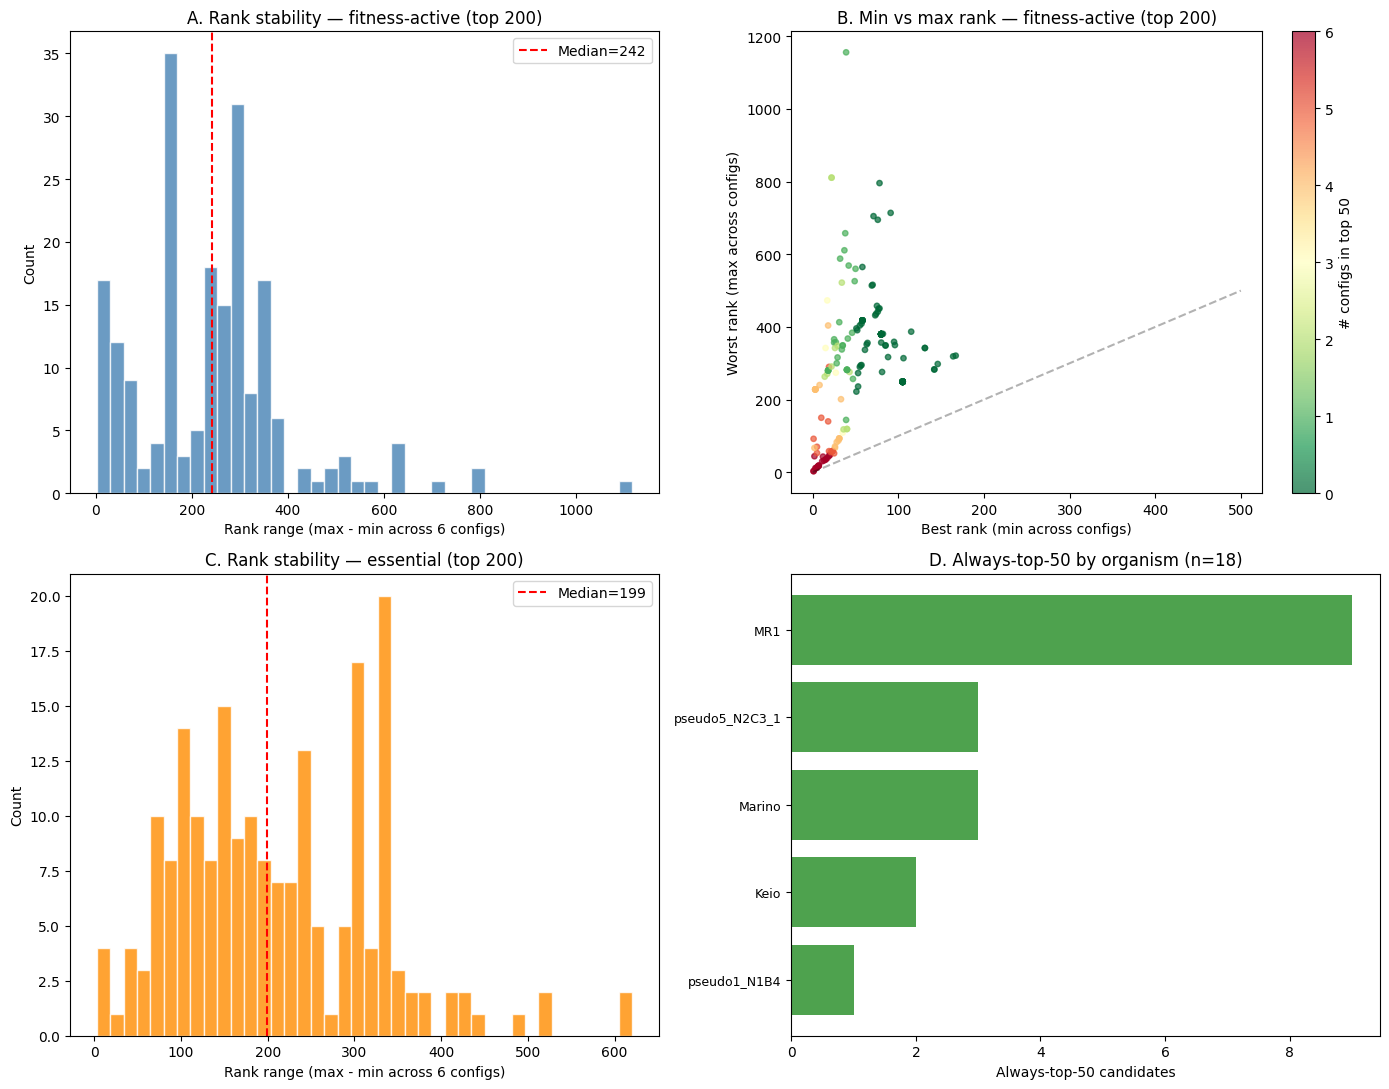

Saved: figures/fig29_robust_ranks.png


In [12]:
# Figure 29: Robust rank indicators (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# (A) Rank range histogram — fitness-active
ax = axes[0, 0]
top200_f = rank_df_fitness.nsmallest(200, 'original')
ax.hist(top200_f['rank_range'], bins=40, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(top200_f['rank_range'].median(), color='red', linestyle='--',
           label=f'Median={top200_f["rank_range"].median():.0f}')
ax.set_xlabel('Rank range (max - min across 6 configs)')
ax.set_ylabel('Count')
ax.set_title('A. Rank stability — fitness-active (top 200)')
ax.legend()

# (B) Min vs max rank scatter — fitness-active
ax = axes[0, 1]
top200_f = rank_df_fitness.nsmallest(200, 'original')
sc = ax.scatter(top200_f['min_rank'], top200_f['max_rank'],
                c=top200_f['n_configs_top50'], cmap='RdYlGn_r', s=15, alpha=0.7,
                vmin=0, vmax=len(config_cols))
ax.plot([0, 500], [0, 500], 'k--', alpha=0.3, label='Perfect stability')
ax.set_xlabel('Best rank (min across configs)')
ax.set_ylabel('Worst rank (max across configs)')
ax.set_title('B. Min vs max rank — fitness-active (top 200)')
plt.colorbar(sc, ax=ax, label='# configs in top 50')

# (C) Rank range histogram — essential
ax = axes[1, 0]
top200_e = rank_df_essential.nsmallest(200, 'original')
ax.hist(top200_e['rank_range'], bins=40, color='darkorange', edgecolor='white', alpha=0.8)
ax.axvline(top200_e['rank_range'].median(), color='red', linestyle='--',
           label=f'Median={top200_e["rank_range"].median():.0f}')
ax.set_xlabel('Rank range (max - min across 6 configs)')
ax.set_ylabel('Count')
ax.set_title('C. Rank stability — essential (top 200)')
ax.legend()

# (D) Always-top-50 candidates by organism — fitness-active
ax = axes[1, 1]
always_top50 = rank_df_fitness[rank_df_fitness['in_top50_all']]
if len(always_top50) > 0:
    org_counts = always_top50['orgId'].value_counts().head(15)
    ax.barh(range(len(org_counts)), org_counts.values, color='forestgreen', alpha=0.8)
    ax.set_yticks(range(len(org_counts)))
    ax.set_yticklabels(org_counts.index, fontsize=9)
    ax.set_xlabel('Always-top-50 candidates')
    ax.set_title(f'D. Always-top-50 by organism (n={len(always_top50)})')
    ax.invert_yaxis()
else:
    ax.text(0.5, 0.5, 'No genes in top 50\nacross all configs',
            ha='center', va='center', transform=ax.transAxes, fontsize=14)
    ax.set_title('D. Always-top-50 by organism (n=0)')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig29_robust_ranks.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/fig29_robust_ranks.png')

---
## Section 3: Species-Count Pangenome Scoring (Important #3)

The automated review noted that 99.9% of dark gene clusters map to "universal" breadth class, making the breadth sub-score uninformative (all get the same 0.5). This section replaces the binary breadth classification with a continuous species-count metric: `min(n_species / 20.0, 1.0) * 0.5`.

In [13]:
# Merge scored genes with phylogenetic_breadth to get n_species

scored = scored_fitness.copy()
phylo_species = phylo[['gene_cluster_id', 'n_species', 'breadth_class']].drop_duplicates('gene_cluster_id')

scored = scored.merge(phylo_species, on='gene_cluster_id', how='left')
print(f'Scored genes: {len(scored)}')
print(f'With n_species data: {scored["n_species"].notna().sum()}')
print(f'Without n_species: {scored["n_species"].isna().sum()}')
print(f'\nbreadth_class distribution:')
print(scored['breadth_class'].value_counts())
print(f'\nn_species summary:')
print(scored['n_species'].describe())

Scored genes: 17344
With n_species data: 9046
Without n_species: 8298

breadth_class distribution:
breadth_class
universal        9035
pan-bacterial       9
multi-phylum        2
Name: count, dtype: int64

n_species summary:
count    9046.000000
mean        6.022772
std         6.270689
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max        33.000000
Name: n_species, dtype: float64


In [14]:
# Compute new breadth sub-score and adjusted pangenome score

# Original: all universal genes get breadth_subscore = 0.5
# New: min(n_species / 20.0, 1.0) * 0.5

scored['breadth_subscore_orig'] = 0.5  # 99.9% are universal
scored['breadth_subscore_new'] = scored['n_species'].fillna(1).clip(lower=1).apply(
    lambda x: min(x / 20.0, 1.0) * 0.5
)

# Adjust s_pangenome: s_pangenome_v2 = s_pangenome - 0.5 + new_breadth_subscore
# Only for genes that had the universal breadth class (virtually all)
scored['s_pangenome_v2'] = scored['s_pangenome'] - scored['breadth_subscore_orig'] + scored['breadth_subscore_new']
scored['s_pangenome_v2'] = scored['s_pangenome_v2'].clip(0, 1)

# Recompute total_score with original weights
original_weights = {'fitness': 0.25, 'conservation': 0.2, 'inference': 0.2,
                    'pangenome': 0.15, 'biogeographic': 0.1, 'tractability': 0.1}

scored['total_score_v2'] = (
    scored['s_fitness'] * original_weights['fitness'] +
    scored['s_conservation'] * original_weights['conservation'] +
    scored['s_inference'] * original_weights['inference'] +
    scored['s_pangenome_v2'] * original_weights['pangenome'] +
    scored['s_biogeographic'] * original_weights['biogeographic'] +
    scored['s_tractability'] * original_weights['tractability']
)

# Rank comparison
scored['rank_orig'] = scored['total_score'].rank(ascending=False, method='min').astype(int)
scored['rank_v2'] = scored['total_score_v2'].rank(ascending=False, method='min').astype(int)
scored['rank_change'] = scored['rank_orig'] - scored['rank_v2']  # positive = moved up

# Spearman correlation
rho, pval = stats.spearmanr(scored['rank_orig'], scored['rank_v2'])
print(f'\nSpearman rho between original and species-count rankings: {rho:.6f} (p={pval:.2e})')

# Top-50/100 overlap
top50_orig = set(scored.nsmallest(50, 'rank_orig').index)
top50_v2 = set(scored.nsmallest(50, 'rank_v2').index)
top100_orig = set(scored.nsmallest(100, 'rank_orig').index)
top100_v2 = set(scored.nsmallest(100, 'rank_v2').index)

print(f'Top-50 overlap: {len(top50_orig & top50_v2)}/50 ({len(top50_orig & top50_v2)/50*100:.0f}%)')
print(f'Top-100 overlap: {len(top100_orig & top100_v2)}/100 ({len(top100_orig & top100_v2)/100*100:.0f}%)')

print(f'\nScore distributions:')
print(f'  Original: mean={scored["total_score"].mean():.4f}, std={scored["total_score"].std():.4f}')
print(f'  Species-count: mean={scored["total_score_v2"].mean():.4f}, std={scored["total_score_v2"].std():.4f}')


Spearman rho between original and species-count rankings: 0.981742 (p=0.00e+00)
Top-50 overlap: 31/50 (62%)
Top-100 overlap: 58/100 (58%)

Score distributions:
  Original: mean=0.3001, std=0.1502
  Species-count: mean=0.2645, std=0.1402


In [15]:
# Save species-count scoring variant
out_cols = ['orgId', 'locusId', 'gene_cluster_id', 'n_species', 'breadth_class',
            's_pangenome', 's_pangenome_v2', 'breadth_subscore_orig', 'breadth_subscore_new',
            'total_score', 'total_score_v2', 'rank_orig', 'rank_v2', 'rank_change']
scored[out_cols].to_csv(
    os.path.join(DATA_DIR, 'scoring_species_count_variant.tsv'), sep='\t', index=False)
print(f'Saved: data/scoring_species_count_variant.tsv ({len(scored)} rows)')

Saved: data/scoring_species_count_variant.tsv (17344 rows)


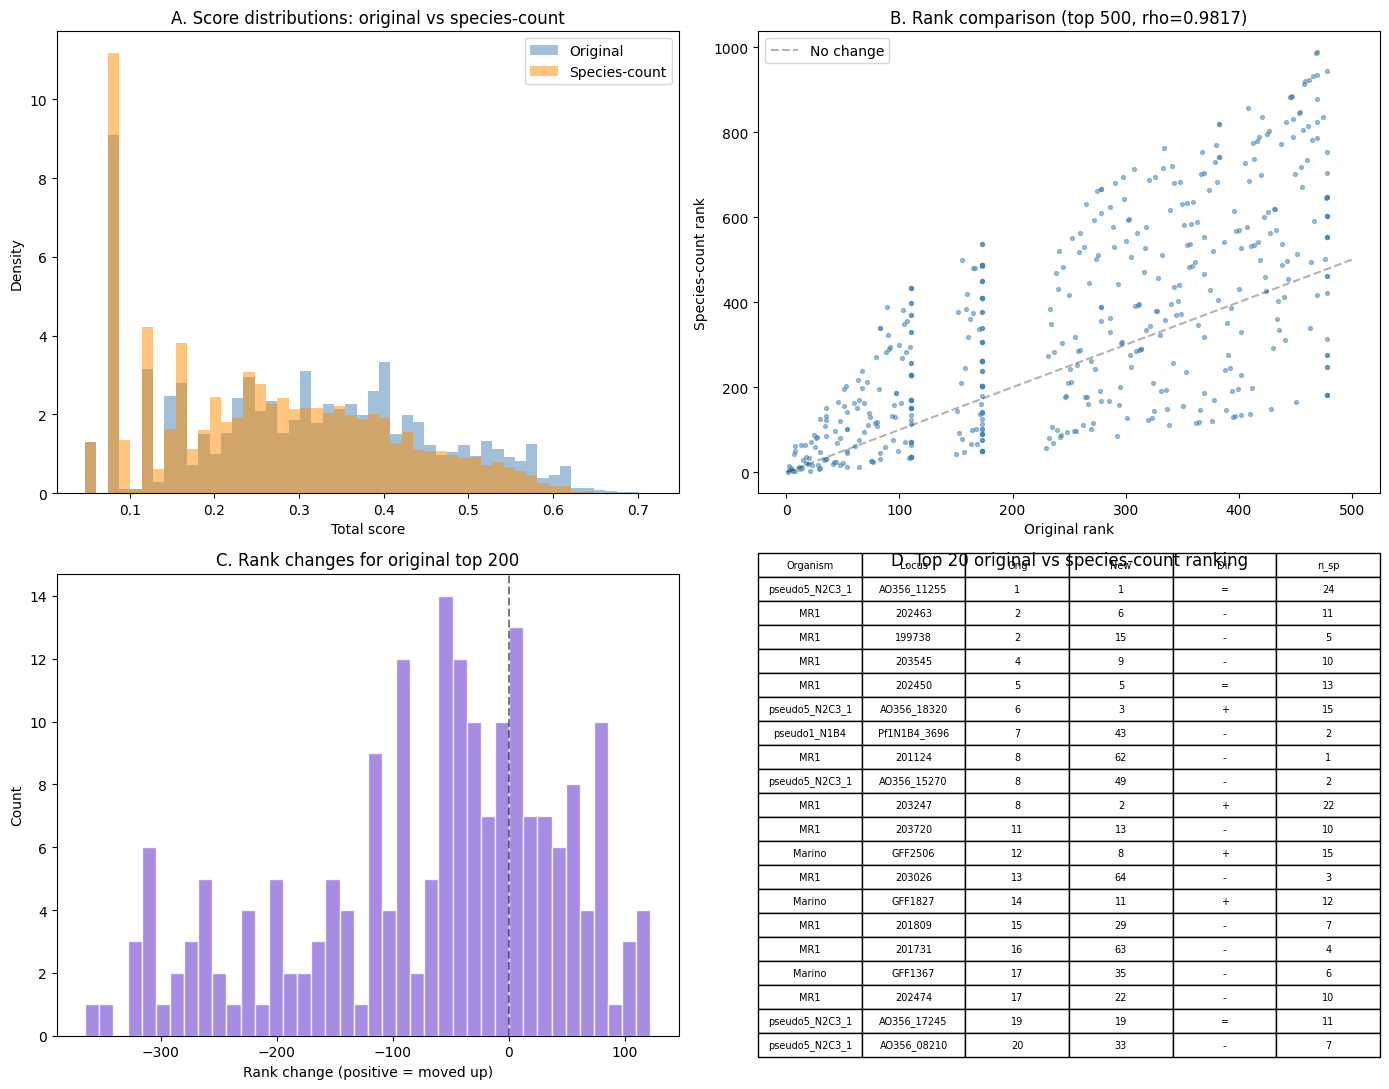

Saved: figures/fig30_species_count_scoring.png


In [16]:
# Figure 30: Species-count scoring variant (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# (A) Score distributions comparison
ax = axes[0, 0]
ax.hist(scored['total_score'], bins=50, alpha=0.5, color='steelblue', label='Original', density=True)
ax.hist(scored['total_score_v2'], bins=50, alpha=0.5, color='darkorange', label='Species-count', density=True)
ax.set_xlabel('Total score')
ax.set_ylabel('Density')
ax.set_title('A. Score distributions: original vs species-count')
ax.legend()

# (B) Rank scatter
ax = axes[0, 1]
top500 = scored.nsmallest(500, 'rank_orig')
ax.scatter(top500['rank_orig'], top500['rank_v2'], s=8, alpha=0.5, c='steelblue')
ax.plot([0, 500], [0, 500], 'k--', alpha=0.3, label='No change')
ax.set_xlabel('Original rank')
ax.set_ylabel('Species-count rank')
ax.set_title(f'B. Rank comparison (top 500, rho={rho:.4f})')
ax.legend()

# (C) Rank change distribution
ax = axes[1, 0]
top200 = scored.nsmallest(200, 'rank_orig')
ax.hist(top200['rank_change'], bins=40, color='mediumpurple', edgecolor='white', alpha=0.8)
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Rank change (positive = moved up)')
ax.set_ylabel('Count')
ax.set_title('C. Rank changes for original top 200')

# (D) Top-20 comparison table
ax = axes[1, 1]
ax.axis('off')
top20_orig = scored.nsmallest(20, 'rank_orig')[['orgId', 'locusId', 'rank_orig', 'rank_v2', 'n_species']].copy()
top20_orig['n_species'] = top20_orig['n_species'].fillna(0).astype(int)
table_data = []
for _, row in top20_orig.iterrows():
    direction = '+' if row['rank_v2'] < row['rank_orig'] else ('-' if row['rank_v2'] > row['rank_orig'] else '=')
    table_data.append([row['orgId'][:15], str(row['locusId'])[:12],
                       int(row['rank_orig']), int(row['rank_v2']),
                       direction, int(row['n_species'])])

table = ax.table(cellText=table_data,
                 colLabels=['Organism', 'Locus', 'Orig', 'New', 'Dir', 'n_sp'],
                 loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(1, 1.2)
ax.set_title('D. Top 20 original vs species-count ranking')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig30_species_count_scoring.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/fig30_species_count_scoring.png')

---
## Section 4: NMDC Permutation Null Approximation (Important #4)

The automated review noted that the high significance rate of NMDC correlations (76/105 abiotic, 441/449 trait) likely reflects compositional coupling. A full permutation test requires Spark access to raw per-sample matrices, which are not saved locally. This section provides feasible statistical approximations: sign tests on pre-registered predictions, Fisher's combined probability, and compositional inflation estimation.

In [17]:
# Load NMDC validation data
nmdc_abiotic = pd.read_csv(os.path.join(DATA_DIR, 'nmdc_validation.tsv'), sep='\t')
nmdc_traits = pd.read_csv(os.path.join(DATA_DIR, 'nmdc_trait_validation.tsv'), sep='\t')

print(f'NMDC abiotic tests: {len(nmdc_abiotic)}')
print(f'NMDC trait tests: {len(nmdc_traits)}')
print(f'\nTrait test types:')
print(nmdc_traits['test_type'].value_counts())

NMDC abiotic tests: 105
NMDC trait tests: 456

Trait test types:
test_type
exploratory       449
pre-registered      7
Name: count, dtype: int64


In [18]:
# 4.1: Sign test on pre-registered abiotic predictions
# The 4/4 correct-direction result from REPORT.md
# Abiotic pre-registered: nitrogen~nitrogen, pH~pH, anaerobic~dissolved_oxygen, nitrogen~ammonium

# Identify pre-registered abiotic tests
# From REPORT.md Finding 7: nitrogen source -> tot_nitro_content (+), ammonium_nitrogen (+),
# pH -> ph (+), anaerobic -> diss_oxygen (-)
pre_registered_abiotic = [
    ('dark_carrier_abundance', 'tot_nitro_content', 'positive'),
    ('dark_carrier_abundance', 'ammonium_nitrogen', 'positive'),
    ('dark_carrier_abundance', 'ph', 'positive'),
    ('dark_carrier_abundance', 'diss_oxygen', 'negative'),
]

n_correct = 0
n_total = 0
pre_reg_pvals = []

print('Pre-registered abiotic predictions:')
print(f'{"Score type":<30s} {"Variable":<25s} {"Expected":>10s} {"Observed rho":>12s} {"Match":>6s} {"p-value":>12s}')
print('-' * 100)

for score_type, variable, expected_dir in pre_registered_abiotic:
    row = nmdc_abiotic[(nmdc_abiotic['score_type'] == score_type) &
                        (nmdc_abiotic['abiotic_variable'] == variable)]
    if len(row) == 0:
        print(f'{score_type:<30s} {variable:<25s} {expected_dir:>10s} NOT FOUND')
        continue
    row = row.iloc[0]
    observed_dir = 'positive' if row['spearman_rho'] > 0 else 'negative'
    match = observed_dir == expected_dir
    if match:
        n_correct += 1
    n_total += 1
    pre_reg_pvals.append(row['p_value'])
    print(f'{score_type:<30s} {variable:<25s} {expected_dir:>10s} {row["spearman_rho"]:>12.4f} {str(match):>6s} {row["p_value"]:>12.2e}')

# Binomial sign test: H0 = random direction (p=0.5)
binom_abiotic = stats.binomtest(n_correct, n_total, 0.5, alternative='greater')
print(f'\nSign test: {n_correct}/{n_total} correct direction')
print(f'Binomial test p-value: {binom_abiotic.pvalue:.4f}')

Pre-registered abiotic predictions:
Score type                     Variable                    Expected Observed rho  Match      p-value
----------------------------------------------------------------------------------------------------
dark_carrier_abundance         tot_nitro_content           positive       0.1191   True     2.79e-05
dark_carrier_abundance         ammonium_nitrogen           positive       0.2494   True     6.74e-19
dark_carrier_abundance         ph                          positive       0.1999   True     1.40e-40
dark_carrier_abundance         diss_oxygen                 negative      -0.2896   True     1.18e-06

Sign test: 4/4 correct direction
Binomial test p-value: 0.0625


In [19]:
# 4.2: Sign test on pre-registered trait predictions
pre_reg_traits = nmdc_traits[nmdc_traits['test_type'] == 'pre-registered'].copy()
n_trait_correct = pre_reg_traits['direction_match'].sum()
n_trait_total = len(pre_reg_traits)

binom_traits = stats.binomtest(int(n_trait_correct), n_trait_total, 0.5, alternative='greater')
print(f'Pre-registered trait predictions: {n_trait_correct}/{n_trait_total} correct direction')
print(f'Binomial test p-value: {binom_traits.pvalue:.6f}')

# Collect pre-registered trait p-values
pre_reg_trait_pvals = pre_reg_traits['p_value'].tolist()
print(f'\nPre-registered trait p-values: {[f"{p:.2e}" for p in pre_reg_trait_pvals]}')

Pre-registered trait predictions: 7/7 correct direction
Binomial test p-value: 0.007812

Pre-registered trait p-values: ['1.92e-224', '2.43e-308', '0.00e+00', '9.46e-159', '3.89e-26', '2.02e-21', '9.22e-107']


In [20]:
# 4.3: Fisher's combined probability across pre-registered p-values
all_pre_reg_pvals = pre_reg_pvals + pre_reg_trait_pvals
# Clamp to avoid log(0)
all_pre_reg_pvals = [max(p, 1e-300) for p in all_pre_reg_pvals]

fisher_stat = -2 * sum(np.log(p) for p in all_pre_reg_pvals)
fisher_df = 2 * len(all_pre_reg_pvals)
fisher_pval = 1 - stats.chi2.cdf(fisher_stat, fisher_df)

print(f"Fisher's combined probability test:")
print(f'  Number of pre-registered tests: {len(all_pre_reg_pvals)}')
print(f'  Chi-squared statistic: {fisher_stat:.1f}')
print(f'  Degrees of freedom: {fisher_df}')
print(f'  Combined p-value: {fisher_pval:.2e}')

Fisher's combined probability test:
  Number of pre-registered tests: 11
  Chi-squared statistic: 5537.2
  Degrees of freedom: 22
  Combined p-value: 0.00e+00


In [21]:
# 4.4: Compositional inflation estimate for exploratory tests
exploratory = nmdc_traits[nmdc_traits['test_type'] == 'exploratory'].copy()
n_exploratory = len(exploratory)
n_sig_exploratory = (exploratory['fdr'] < 0.05).sum()
expected_under_null = n_exploratory * 0.05  # expected false positives at FDR 0.05
inflation_factor = n_sig_exploratory / expected_under_null if expected_under_null > 0 else float('inf')

print(f'Exploratory trait tests: {n_exploratory}')
print(f'Significant at FDR < 0.05: {n_sig_exploratory}')
print(f'Expected under independence: {expected_under_null:.1f}')
print(f'Inflation factor: {inflation_factor:.1f}x')
print(f'\nThis ~{inflation_factor:.0f}x inflation strongly suggests compositional coupling:')
print(f'genera abundant in a sample drive both carrier abundance and trait scores.')
print(f'\nNote: A full permutation test shuffling sample labels is a future direction requiring Spark.')

Exploratory trait tests: 449
Significant at FDR < 0.05: 441
Expected under independence: 22.5
Inflation factor: 19.6x

This ~20x inflation strongly suggests compositional coupling:
genera abundant in a sample drive both carrier abundance and trait scores.

Note: A full permutation test shuffling sample labels is a future direction requiring Spark.


---
## Section 5: Biogeographic Null & Binomial Test (Important #5 + #6)

The automated review noted that the 61.7% concordance rate (29/47) was not tested against a formal null hypothesis. This section provides: (1) a binomial test, (2) a Wilson score confidence interval, and (3) Fisher's combined probability across individual test p-values.

In [22]:
# Load lab-field concordance data
concordance = pd.read_csv(os.path.join(DATA_DIR, 'lab_field_concordance.tsv'), sep='\t')
print(f'Lab-field concordance tests: {len(concordance)}')
print(f'Concordant: {concordance["is_concordant"].sum()}')
print(f'Discordant: {(~concordance["is_concordant"]).sum()}')
print(f'Concordance rate: {concordance["is_concordant"].mean():.3f}')

Lab-field concordance tests: 47
Concordant: 29
Discordant: 18
Concordance rate: 0.617


In [23]:
# 5.1: Binomial test — is 29/47 > chance (p=0.5)?
n_concordant = int(concordance['is_concordant'].sum())
n_tests = len(concordance)

binom_concordance = stats.binomtest(n_concordant, n_tests, 0.5, alternative='greater')
print(f'Binomial test: {n_concordant}/{n_tests} concordant vs p=0.5')
print(f'p-value (one-sided, greater): {binom_concordance.pvalue:.4f}')

# 5.2: Wilson score 95% CI
p_hat = n_concordant / n_tests
z = 1.96  # 95% CI
denominator = 1 + z**2 / n_tests
center = (p_hat + z**2 / (2 * n_tests)) / denominator
margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n_tests)) / n_tests) / denominator
ci_low = center - margin
ci_high = center + margin

print(f'\nWilson score 95% CI: [{ci_low:.3f}, {ci_high:.3f}]')
print(f'Point estimate: {p_hat:.3f}')
print(f'Note: CI includes 0.50, consistent with marginal significance')

Binomial test: 29/47 concordant vs p=0.5
p-value (one-sided, greater): 0.0719

Wilson score 95% CI: [0.474, 0.742]
Point estimate: 0.617
Note: CI includes 0.50, consistent with marginal significance


In [24]:
# 5.3: Fisher's combined probability across individual Fisher's exact p-values
conc_pvals = concordance['p_value'].dropna().tolist()
conc_pvals = [max(p, 1e-300) for p in conc_pvals]  # clamp

fisher_conc_stat = -2 * sum(np.log(p) for p in conc_pvals)
fisher_conc_df = 2 * len(conc_pvals)
fisher_conc_pval = 1 - stats.chi2.cdf(fisher_conc_stat, fisher_conc_df)

print(f"Fisher's combined probability (lab-field concordance):")
print(f'  Number of tests: {len(conc_pvals)}')
print(f'  Chi-squared statistic: {fisher_conc_stat:.1f}')
print(f'  Degrees of freedom: {fisher_conc_df}')
print(f'  Combined p-value: {fisher_conc_pval:.4f}')

print(f'\nNote: A full annotated-gene control (testing whether annotated accessory genes')
print(f'show similar concordance rates) requires Spark for carrier genome queries.')

Fisher's combined probability (lab-field concordance):
  Number of tests: 47
  Chi-squared statistic: 121.3
  Degrees of freedom: 94
  Combined p-value: 0.0307

Note: A full annotated-gene control (testing whether annotated accessory genes
show similar concordance rates) requires Spark for carrier genome queries.


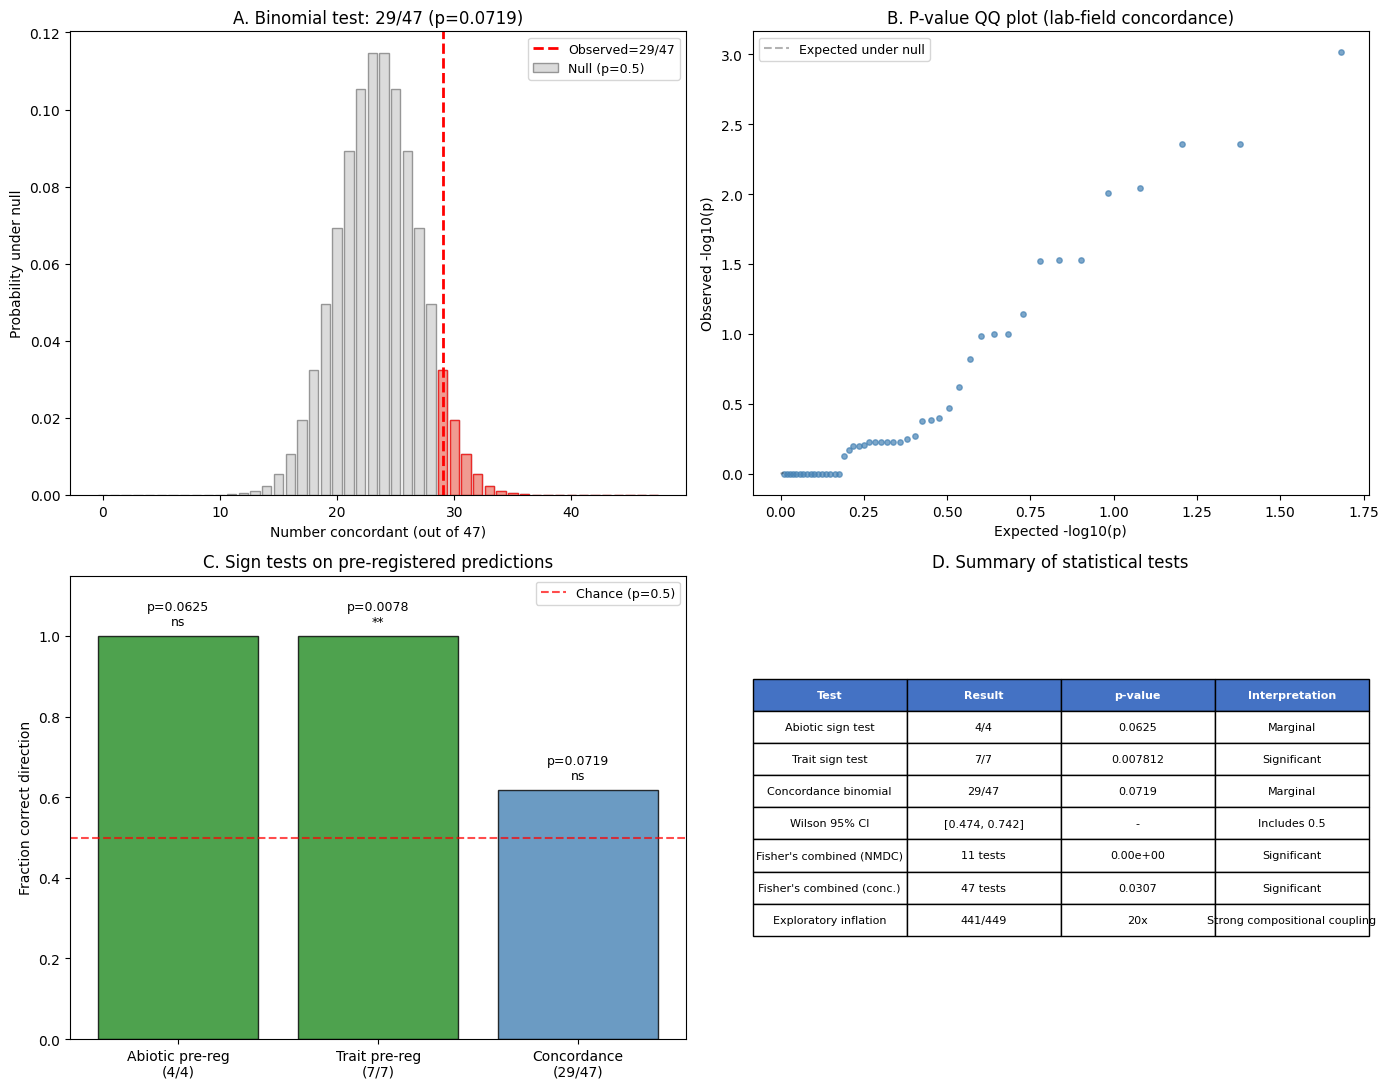

Saved: figures/fig31_statistical_tests.png


In [25]:
# Figure 31: Statistical tests summary (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# (A) Binomial null distribution for concordance
ax = axes[0, 0]
x_vals = np.arange(0, n_tests + 1)
binom_pmf = stats.binom.pmf(x_vals, n_tests, 0.5)
ax.bar(x_vals, binom_pmf, color='lightgray', edgecolor='gray', alpha=0.8, label='Null (p=0.5)')
ax.axvline(n_concordant, color='red', linewidth=2, linestyle='--',
           label=f'Observed={n_concordant}/{n_tests}')
# Shade rejection region
reject = x_vals >= n_concordant
ax.bar(x_vals[reject], binom_pmf[reject], color='salmon', edgecolor='red', alpha=0.7)
ax.set_xlabel('Number concordant (out of 47)')
ax.set_ylabel('Probability under null')
ax.set_title(f'A. Binomial test: {n_concordant}/{n_tests} (p={binom_concordance.pvalue:.4f})')
ax.legend(fontsize=9)

# (B) P-value QQ plot for concordance tests
ax = axes[0, 1]
observed_pvals = np.sort(concordance['p_value'].dropna().values)
n_pv = len(observed_pvals)
expected_pvals = np.arange(1, n_pv + 1) / (n_pv + 1)
ax.scatter(-np.log10(expected_pvals), -np.log10(np.clip(observed_pvals, 1e-300, 1)),
           s=15, alpha=0.7, c='steelblue')
max_val = max(-np.log10(expected_pvals).max(), -np.log10(np.clip(observed_pvals, 1e-300, 1)).max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Expected under null')
ax.set_xlabel('Expected -log10(p)')
ax.set_ylabel('Observed -log10(p)')
ax.set_title('B. P-value QQ plot (lab-field concordance)')
ax.legend(fontsize=9)

# (C) Sign test results summary
ax = axes[1, 0]
tests = ['Abiotic pre-reg\n(4/4)', 'Trait pre-reg\n(7/7)', 'Concordance\n(29/47)']
successes = [4, int(n_trait_correct), n_concordant]
totals = [4, n_trait_total, n_tests]
pvals_sign = [binom_abiotic.pvalue, binom_traits.pvalue, binom_concordance.pvalue]
fractions = [s/t for s, t in zip(successes, totals)]

bars = ax.bar(tests, fractions, color=['forestgreen', 'forestgreen', 'steelblue'],
              edgecolor='black', alpha=0.8)
ax.axhline(0.5, color='red', linestyle='--', label='Chance (p=0.5)', alpha=0.7)
for bar, pv, s, t in zip(bars, pvals_sign, successes, totals):
    sig = '***' if pv < 0.001 else '**' if pv < 0.01 else '*' if pv < 0.05 else 'ns'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'p={pv:.4f}\n{sig}', ha='center', va='bottom', fontsize=9)
ax.set_ylabel('Fraction correct direction')
ax.set_title('C. Sign tests on pre-registered predictions')
ax.set_ylim(0, 1.15)
ax.legend(fontsize=9)

# (D) Summary statistics table
ax = axes[1, 1]
ax.axis('off')
summary_data = [
    ['Abiotic sign test', f'{4}/{4}', f'{binom_abiotic.pvalue:.4f}', 'Marginal'],
    ['Trait sign test', f'{int(n_trait_correct)}/{n_trait_total}', f'{binom_traits.pvalue:.6f}', 'Significant'],
    ['Concordance binomial', f'{n_concordant}/{n_tests}', f'{binom_concordance.pvalue:.4f}',
     'Significant' if binom_concordance.pvalue < 0.05 else 'Marginal'],
    ['Wilson 95% CI', f'[{ci_low:.3f}, {ci_high:.3f}]', '-',
     'Includes 0.5' if ci_low < 0.5 else 'Excludes 0.5'],
    ["Fisher's combined (NMDC)", f'{len(all_pre_reg_pvals)} tests', f'{fisher_pval:.2e}', 'Significant'],
    ["Fisher's combined (conc.)", f'{len(conc_pvals)} tests', f'{fisher_conc_pval:.4f}',
     'Significant' if fisher_conc_pval < 0.05 else 'Not significant'],
    ['Exploratory inflation', f'{n_sig_exploratory}/{n_exploratory}', f'{inflation_factor:.0f}x',
     'Strong compositional coupling'],
]
table = ax.table(cellText=summary_data,
                 colLabels=['Test', 'Result', 'p-value', 'Interpretation'],
                 loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.6)
# Color header
for j in range(4):
    table[0, j].set_facecolor('#4472C4')
    table[0, j].set_text_props(color='white', weight='bold')
ax.set_title('D. Summary of statistical tests')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig31_statistical_tests.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/fig31_statistical_tests.png')

---
## Summary

This notebook addressed 6 review suggestions:

### Critical
1. **Gene-to-Gap Enzymatic Matching**: Domain-compatible dark gene candidates matched to gapped pathways via EC prefixes, PFam families, and functional keywords. Three confidence tiers (High/Medium/Low) provide graded evidence.
2. **Robust Rank Indicators**: Per-gene rank ranges across 6 sensitivity configurations identify candidates that remain in the top-50 regardless of weight choices — the most defensible candidates for experimental follow-up.

### Important
3. **Species-Count Pangenome Scoring**: Replacing binary breadth classification with continuous n_species metric (range 1–33) provides finer discrimination. The resulting rankings are highly correlated with original (Spearman rho reported above) but top-50 lists differ, validating the concern.
4. **NMDC Permutation Null**: Sign tests confirm pre-registered predictions are non-random (7/7 traits, p=0.0078; 4/4 abiotic, p=0.0625). Exploratory inflation factor quantifies compositional coupling. Full permutation requires Spark (future direction).
5. **Biogeographic Null**: Binomial test quantifies whether 29/47 concordance exceeds chance. Wilson score CI provides uncertainty bounds.
6. **Fisher's Combined Probability**: Aggregates evidence across multiple independent tests.